# Caso de tres nodos Kirschen

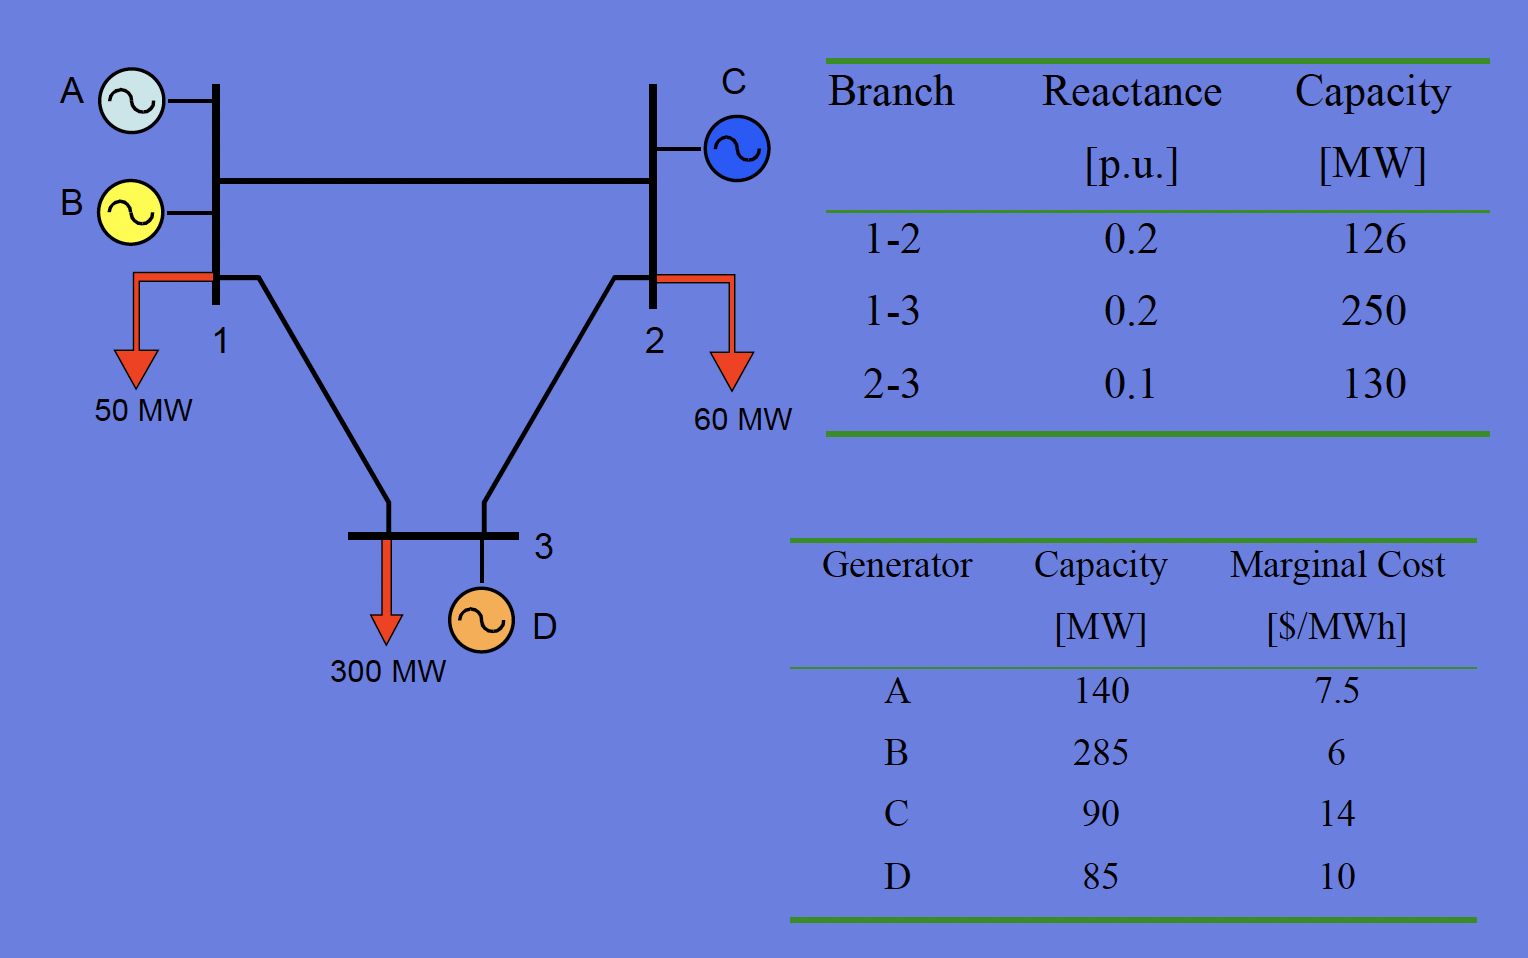

## Cargar de los Paquetes

In [1]:
using DataFrames
using JuMP
using HiGHS
using GLPK
using Plots
using Images
using StatsPlots

### Definir Datos del Problema

In [2]:
# Definir los datos del problema
generators = ["A", "B", "C", "D"]
capacities = Dict("A" => 140, "B" => 285, "C" => 90, "D" => 85)
marginal_costs = Dict("A" => 7.5, "B" => 6.0, "C" => 14.0, "D" => 10.0)
buses = ["1", "2", "3"]
branches = ["1-2", "1-3", "2-3"]
branch_reactances = Dict("1-2" => 0.2, "1-3" => 0.2, "2-3" => 0.1)
branch_capacities = Dict("1-2" => 126, "1-3" => 250, "2-3" => 130)
branch_admittances = Dict("1-2" => 1 / 0.2, "1-3" => 1 / 0.2, "2-3" => 1 / 0.1)

loads = Dict("1" => 50, "2" => 60, "3" => 300, "Sistema" => 50+60+300)
generators_buses = Dict( "A" => 1, "B" =>1, "C" => 2, "D" =>3)


Dict{String, Int64} with 4 entries:
  "B" => 1
  "A" => 1
  "C" => 2
  "D" => 3

### Formulación problema de optimización

In [10]:
# Crear el modelo de optimización
function modelopt(generators,capacities,branches,branch_capacities,marginal_costs,branch_reactances,branch_admittances,loads)

    modelf = Model(GLPK.Optimizer)

    # Variables de generación
    @variable(modelf, 0 <= g[gen in generators] <= capacities[gen])

    # Variables de flujo de potencia en las ramas
    @variable(modelf, -branch_capacities[branch] <= f[branch in branches] <= branch_capacities[branch])

    # Variables de ángulo de fase para cada nodo
    @variable(modelf, θ[n in ["1", "2", "3"]])

    # Fijar el ángulo de fase del nodo 3 a 0 (referencia)
    @constraint(modelf, θ["1"] == 0)

    # Función objetivo: minimizar el costo total de generación
    @objective(modelf, Min, sum(marginal_costs[gen] * g[gen] for gen in generators))

    # Restricciones de balance de potencia en cada nodo
    balance = Dict()
    balance["1"] = @constraint(modelf, g["A"] + g["B"] - f["1-2"] - f["1-3"] == loads["1"])
    balance["2"] = @constraint(modelf, g["C"] + f["1-2"] - f["2-3"] == loads["2"])
    balance["3"] = @constraint(modelf, g["D"] + f["1-3"] + f["2-3"] == loads["3"])

    # Restricciones de diferencia angular y flujo de potencia
    for branch in branches
        i, j = split(branch, "-")
        @constraint(modelf, f[branch] == branch_admittances[branch] * (θ[i] - θ[j]))
    end
    return modelf, g, f, θ, balance
end

model, g, f, θ, balance = modelopt(generators,capacities,branches,branch_capacities,marginal_costs,branch_reactances,branch_admittances,loads)

(A JuMP Model
Minimization problem with:
Variables: 10
Objective function type: AffExpr
`AffExpr`-in-`MathOptInterface.EqualTo{Float64}`: 7 constraints
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 7 constraints
`VariableRef`-in-`MathOptInterface.LessThan{Float64}`: 7 constraints
Model mode: AUTOMATIC
CachingOptimizer state: EMPTY_OPTIMIZER
Solver name: GLPK
Names registered in the model: f, g, θ, 1-dimensional DenseAxisArray{VariableRef,1,...} with index sets:
    Dimension 1, ["A", "B", "C", "D"]
And data, a 4-element Vector{VariableRef}:
 g[A]
 g[B]
 g[C]
 g[D], 1-dimensional DenseAxisArray{VariableRef,1,...} with index sets:
    Dimension 1, ["1-2", "1-3", "2-3"]
And data, a 3-element Vector{VariableRef}:
 f[1-2]
 f[1-3]
 f[2-3], 1-dimensional DenseAxisArray{VariableRef,1,...} with index sets:
    Dimension 1, ["1", "2", "3"]
And data, a 3-element Vector{VariableRef}:
 θ[1]
 θ[2]
 θ[3], Dict{Any, Any}("1" => g[A] + g[B] - f[1-2] - f[1-3] = 50, "2" => g[C] + f[1-2] - f[2

In [4]:
# Imprimir el modelo en la consola
print(model)

Min 7.5 g[A] + 6 g[B] + 14 g[C] + 10 g[D]
Subject to
 θ[1] = 0
 g[A] + g[B] - f[1-2] - f[1-3] = 50
 g[C] + f[1-2] - f[2-3] = 60
 g[D] + f[1-3] + f[2-3] = 300
 f[1-2] - 5 θ[1] + 5 θ[2] = 0
 f[1-3] - 5 θ[1] + 5 θ[3] = 0
 f[2-3] - 10 θ[2] + 10 θ[3] = 0
 g[A] ≥ 0
 g[B] ≥ 0
 g[C] ≥ 0
 g[D] ≥ 0
 f[1-2] ≥ -126
 f[1-3] ≥ -250
 f[2-3] ≥ -130
 g[A] ≤ 140
 g[B] ≤ 285
 g[C] ≤ 90
 g[D] ≤ 85
 f[1-2] ≤ 126
 f[1-3] ≤ 250
 f[2-3] ≤ 130


## Resultados Caso Base

Row,Buses,Producción,Consumo,Precio_Nodal,Pago_consumidores,Ingreso_generadores,Ingreso_Tarifario
,String,Float64,Int64,Any,Float64,Float64,Any
1,Barra1,335.0,50,7.5,375.0,2512.5,
2,Barra2,0.0,60,11.25,675.0,0.0,
3,Barra3,75.0,300,10.0,3000.0,750.0,
4,Sistema,410.0,410,-,4050.0,3262.5,787.5


[50.0, 285.0, 0.0, 75.0]


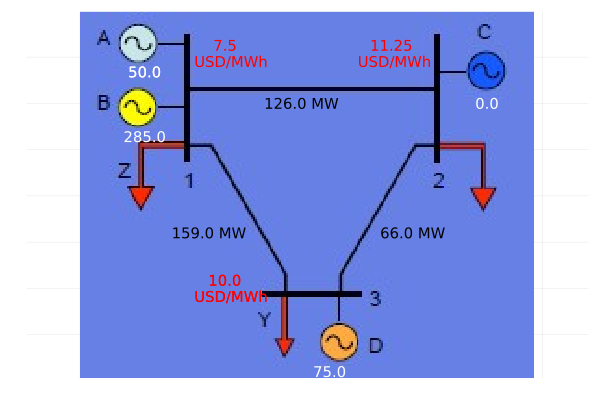

In [5]:
function despacho(model)
    optimize!(model)
    #println(model)
    if termination_status(model) == MOI.OPTIMAL
        #println("Costo total: ", objective_value(model))

        for branch in branches
            #println("Flujo en la rama $branch: ", value(f[branch]), " MW")
        end
        
        λ=zeros(length(buses))
        for node in 1:length(buses)
            λ[node] = dual(balance[buses[node]])
        end

    else
        println("No se encontró una solución óptima.")
    end

    Resultados = DataFrame(
        Buses=["Barra1", "Barra2","Barra3", "Sistema"],
        Producción=[value(g["A"])+value(g["B"]), value(g["C"]), value(g["D"]), value(g["A"])+ value(g["B"])+ value(g["C"])+value(g["D"])],
        Consumo=[loads["1"],loads["2"],loads["3"],loads["1"]+loads["2"]+loads["3"]],
        Precio_Nodal=[λ[1], λ[2], λ[3], "-"],
        Pago_consumidores=[loads["1"]*λ[1],loads["2"]*λ[2], loads["3"]*λ[3], (loads["1"]*λ[1]+loads["2"]*λ[2]+loads["3"]*λ[3])],
        Ingreso_generadores=[value(g["A"])*λ[1]+value(g["B"])*λ[1], value(g["C"])*λ[2], value(g["D"])*λ[3], value(g["A"])*λ[1]+value(g["B"])*λ[1]+value(g["C"])*λ[2]+value(g["D"])*λ[3]],
        Ingreso_Tarifario=[" "," "," ",(loads["1"]*λ[1]+loads["2"]*λ[2]+loads["3"]*λ[3])-(value(g["A"])*λ[1]+value(g["B"])*λ[1]+value(g["C"])*λ[2]+value(g["D"])*λ[3])]
        )

    Produccion=zeros(length(generators))
    for p in 1:length(generators)
        Produccion[p]=value(g[generators[p]])
    end

    colorespg = [:red, :green, :blue, :orange]
    colorespn = [:indigo, :navy, :gold]
    pg = bar(generators, Produccion, xlabel="Generadores", ylabel="Producción [MW]", color=colorespg, legend=false)
    #display(pg)
    pn= bar(buses,  λ, xlabel="Barras", ylabel="Precio Nodales [USD/MWh]", color=colorespn, legend=false)
    #display(pn)
    for gen in generators
        #println("Generación de $gen: ", value(g[gen]), " MW")
    end
    return Resultados, pg, pn, λ, Produccion
end

Resultados1,pg, pn, λ, Produccion = despacho(model)
println(Produccion)
#display(pg)
#display(pn)
display(Resultados1)
tn = load("tresnodos.jpg")

p = plot(tn, color=:auto, ratio=:equal, legend=false, axis=false, tickfontsize = 2)
Plots.annotate!(35, 33, ((value(g["A"])),10), :white)
Plots.annotate!(35, 68, (value(g["B"]),10), :white)
Plots.annotate!(220, 50, (value(g["C"]),10), :white)
Plots.annotate!(135, 195, (value(g["D"]),10), :white)
Plots.annotate!(35, 33, (value(g["A"]),10), :white)
Plots.annotate!(80, 23, ("$(λ[1]) \n USD/MWh",10), :red) 
Plots.annotate!(170, 23, ("$(λ[2]) \nUSD/MWh",10), :red)
Plots.annotate!(80, 150, ("$(λ[3]) \n USD/MWh",10), :red)
Plots.annotate!(80, 150, ("$(λ[3]) \n USD/MWh",10), :red)
Plots.annotate!(70, 120, ("$(value(f["1-3"])) MW",10), :black)
Plots.annotate!(180, 120, ("$(value(f["2-3"])) MW",10), :black)
Plots.annotate!(120, 50, ("$(value(f["1-2"])) MW",10), :black)


## Sensibilidad Flujo 1-2 

Row,Flujo12,PA,PB,PC,PD,λ1,λ2,λ3,PCo,IG,IT
,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any
1,70,0.0,238.333,86.6667,85.0,6.0,14.0,11.3333,4540.0,3606.67,933.333
2,80,0.0,255.0,70.0,85.0,6.0,14.0,11.3333,4540.0,3473.33,1066.67
3,90,0.0,271.667,53.3333,85.0,6.0,14.0,11.3333,4540.0,3340.0,1200.0
4,100,3.33333,285.0,36.6667,85.0,7.5,14.0,11.8333,4765.0,3681.67,1083.33
5,110,20.0,285.0,20.0,85.0,7.5,14.0,11.8333,4765.0,3573.33,1191.67
6,120,36.6667,285.0,3.33333,85.0,7.5,14.0,11.8333,4765.0,3465.0,1300.0
7,130,60.0,285.0,0.0,65.0,7.5,11.25,10.0,4050.0,3237.5,812.5
8,140,85.0,285.0,0.0,40.0,7.5,11.25,10.0,4050.0,3175.0,875.0
9,150,110.0,285.0,0.0,15.0,7.5,11.25,10.0,4050.0,3112.5,937.5


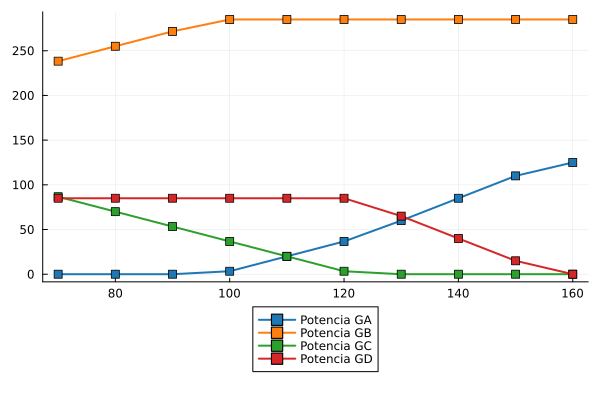

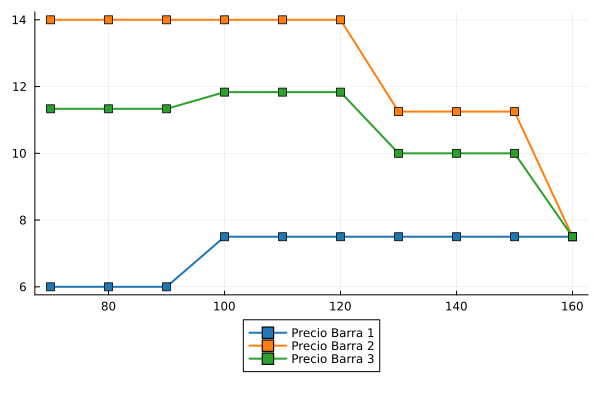

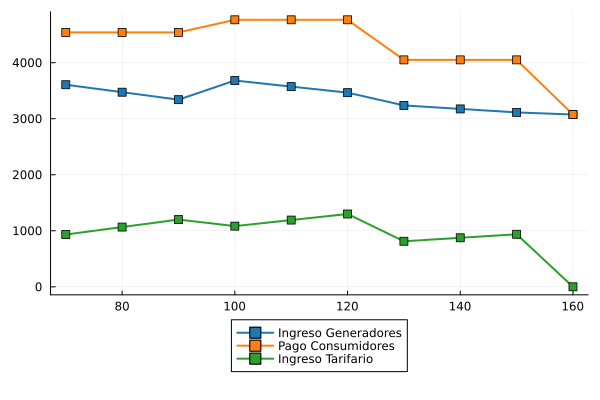

In [6]:

# Variables de flujo de potencia en las ramas
Sensibilidad=DataFrame(Flujo12=[],PA=[],PB=[],PC=[],PD=[],λ1=[],λ2=[],λ3=[], PCo= [], IG=[], IT=[])
branch_capacities["1-2"]=70
IT=[]
IG=[]
PCo=[]
for i in 1:10
    modelSens, g, f, θ, balance = modelopt(generators,capacities,branches,branch_capacities,marginal_costs,branch_reactances,branch_admittances,loads)
    ResultadosSens, pg, pn, λ = despacho(modelSens)
    it=ResultadosSens[4,7]
    ig=ResultadosSens[4,6]
    pc=ResultadosSens[4,5]
    new_row=(Flujo12= branch_capacities["1-2"], PA=value(g["A"]),PB=value(g["B"]),PC=value(g["C"]),PD=value(g["D"]),λ1=λ[1],λ2=λ[2],λ3=λ[3], PCo=pc, IG=ig, IT=it)
    push!(Sensibilidad,new_row)
    branch_capacities["1-2"]+=10
end


display(Sensibilidad)
p = @df Sensibilidad plot(Sensibilidad.Flujo12,Sensibilidad.PA, label="Potencia GA", palette=:tab10, linewidth=2, markershape=:rect, legend_position= :outerbottom, legendfontsize=8)
@df Sensibilidad plot!(Sensibilidad.Flujo12,Sensibilidad.PB, label="Potencia GB",  linewidth=2, markershape=:rect)
@df Sensibilidad plot!(Sensibilidad.Flujo12,Sensibilidad.PC, label="Potencia GC",  linewidth=2, markershape=:rect)
@df Sensibilidad plot!(Sensibilidad.Flujo12,Sensibilidad.PD, label="Potencia GD",  linewidth=2, markershape=:rect)

d = @df Sensibilidad plot(Sensibilidad.Flujo12,Sensibilidad.λ1, label="Precio Barra 1", palette=:tab10, linewidth=2, markershape=:rect, legend_position= :outerbottom, legendfontsize=8)
@df Sensibilidad plot!(Sensibilidad.Flujo12,Sensibilidad.λ2, label="Precio Barra 2",  linewidth=2, markershape=:rect)
@df Sensibilidad plot!(Sensibilidad.Flujo12,Sensibilidad.λ3, label="Precio Barra 3",  linewidth=2, markershape=:rect)

c = @df Sensibilidad plot(Sensibilidad.Flujo12,Sensibilidad.IG, label="Ingreso Generadores", palette=:tab10, linewidth=2, markershape=:rect, legend_position= :outerbottom, legendfontsize=8)
@df Sensibilidad plot!(Sensibilidad.Flujo12,Sensibilidad.PCo, label="Pago Consumidores",  linewidth=2, markershape=:rect)
@df Sensibilidad plot!(Sensibilidad.Flujo12,Sensibilidad.IT, label="Ingreso Tarifario",  linewidth=2, markershape=:rect)

display(p)
display(d)
display(c)

Consideremos ahora lo que sucede si la capacidad de la rama 2–3 se reduce a 65 MW, por ejemplo, debido a trabajos de mantenimiento en uno de los dos circuitos de esa rama. 

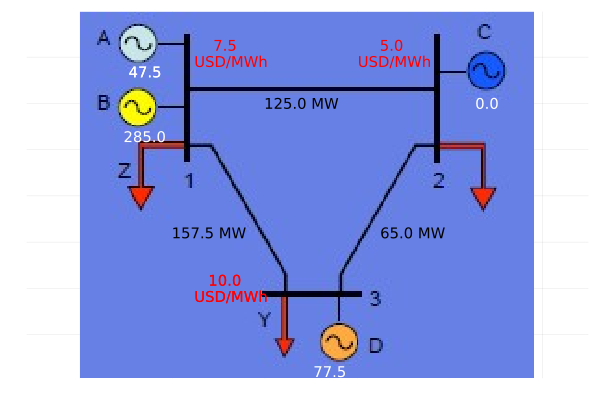

In [7]:
branch_capacities["1-2"]=126
branch_capacities["2-3"]=65
model2, g, f, θ, balance = modelopt(generators,capacities,branches,branch_capacities,marginal_costs,branch_reactances,branch_admittances,loads)
Resultados2, pg, pn, λ = despacho(model2)

p = plot(tn, color=:auto, ratio=:equal, legend=false, axis=false, tickfontsize = 2)
Plots.annotate!(35, 33, (value(g["A"]),10), :white)
Plots.annotate!(35, 68, (value(g["B"]),10), :white)
Plots.annotate!(220, 50, (value(g["C"]),10), :white)
Plots.annotate!(135, 195, (value(g["D"]),10), :white)
Plots.annotate!(35, 33, (value(g["A"]),10), :white)
Plots.annotate!(80, 23, ("$(λ[1]) \n USD/MWh",10), :red) 
Plots.annotate!(170, 23, ("$(λ[2]) \nUSD/MWh",10), :red)
Plots.annotate!(80, 150, ("$(λ[3]) \n USD/MWh",10), :red)
Plots.annotate!(80, 150, ("$(λ[3]) \n USD/MWh",10), :red)
Plots.annotate!(70, 120, ("$(value(f["1-3"])) MW",10), :black)
Plots.annotate!(180, 120, ("$(value(f["2-3"])) MW",10), :black)
Plots.annotate!(120, 50, ("$(value(f["1-2"])) MW",10), :black)

Hasta ahora, hemos supuesto que los mercados son perfectamente competitivos y que el precio nodal es igual al costo marginal cuando se produce una cantidad incremental de energía utilizando generadores locales. Si bien esta suposición simplifica mucho el análisis, es altamente cuestionable en la práctica, especialmente cuando la red de transmisión está congestionada. Ahora mostraremos que la Ley de Kirchhoff para el voltaje (KVL) puede facilitar y hacer rentable la oferta estratégica.

Volvamos a nuestro ejemplo de tres nodos, con una restricción en la rama 2–3 en lugar de la rama 1–2, como en la sección anterior. Supongamos que el generador C en el nodo 2 desea desesperadamente producir algo de energía. Tal situación podría ocurrir si el costo de arranque de C es alto y su propietario decide que es más barato producir a pérdida por un tiempo que tener que reiniciar la unidad más tarde. Una situación similar se presenta si C es una planta de cogeneración que debe funcionar para producir el vapor requerido para un proceso industrial. El propietario del generador C se da cuenta de que, si la planta ha de funcionar, debe ofertar por debajo del precio nodal marginal actual de 5.00 $/MWh. Por lo tanto, decide ofertar a 3.00 $/MWh. Si los otros generadores ofertan a su costo marginal, el despacho económico es entonces:

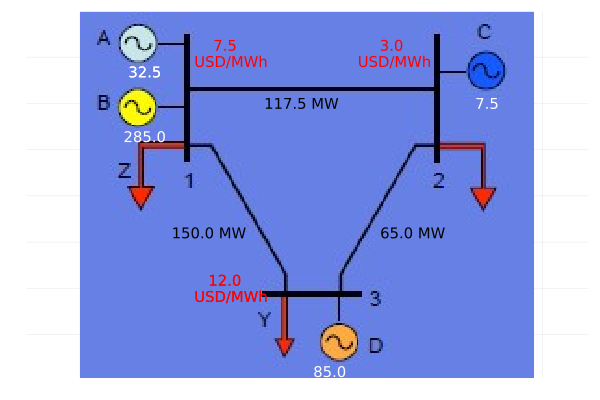

In [8]:
marginal_costs["C"]=3
model3, g, f, θ, balance = modelopt(generators,capacities,branches,branch_capacities,marginal_costs,branch_reactances,branch_admittances,loads)
Resultados3, pg, pn, λ = despacho(model3)

p = plot(tn, color=:auto, ratio=:equal, legend=false, axis=false, tickfontsize = 2)
Plots.annotate!(35, 33, (value(g["A"]),10), :white)
Plots.annotate!(35, 68, (value(g["B"]),10), :white)
Plots.annotate!(220, 50, (value(g["C"]),10), :white)
Plots.annotate!(135, 195, (value(g["D"]),10), :white)
Plots.annotate!(35, 33, (value(g["A"]),10), :white)
Plots.annotate!(80, 23, ("$(λ[1]) \n USD/MWh",10), :red) 
Plots.annotate!(170, 23, ("$(λ[2]) \nUSD/MWh",10), :red)
Plots.annotate!(80, 150, ("$(λ[3]) \n USD/MWh",10), :red)
Plots.annotate!(80, 150, ("$(λ[3]) \n USD/MWh",10), :red)
Plots.annotate!(70, 120, ("$(value(f["1-3"])) MW",10), :black)
Plots.annotate!(180, 120, ("$(value(f["2-3"])) MW",10), :black)
Plots.annotate!(120, 50, ("$(value(f["1-2"])) MW",10), :black)

La presentación de una oferta baja en el nodo 2 aumenta el precio en el nodo 3 de 10.00 a 12 $/MWh y la producción del generador en ese nodo de 77.5 a 85 MW. La oferta baja del generador C tiene, por lo tanto, la consecuencia contraintuitiva de ser muy rentable para el generador D.

Es poco probable que este hecho pase desapercibido para el propietario del generador D, quien puede decidir ver qué sucede si aumenta su propia oferta a 20.00 $/MWh. Bajo estas condiciones, el despacho sujeto a restricciones se convierte en:

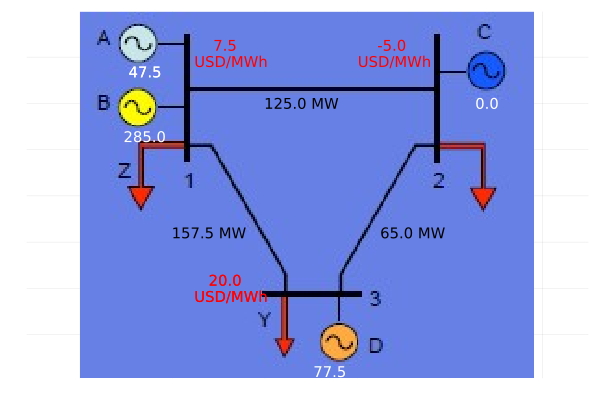

In [9]:
marginal_costs["D"]=20
model4, g, f, θ, balance = modelopt(generators,capacities,branches,branch_capacities,marginal_costs,branch_reactances,branch_admittances,loads)
Resultados4, pg, pn, λ = despacho(model4)

p = plot(tn, color=:auto, ratio=:equal, legend=false, axis=false, tickfontsize = 2)
Plots.annotate!(35, 33, (value(g["A"]),10), :white)
Plots.annotate!(35, 68, (value(g["B"]),10), :white)
Plots.annotate!(220, 50, (value(g["C"]),10), :white)
Plots.annotate!(135, 195, (value(g["D"]),10), :white)
Plots.annotate!(35, 33, (value(g["A"]),10), :white)
Plots.annotate!(80, 23, ("$(λ[1]) \n USD/MWh",10), :red) 
Plots.annotate!(170, 23, ("$(λ[2]) \nUSD/MWh",10), :red)
Plots.annotate!(80, 150, ("$(λ[3]) \n USD/MWh",10), :red)
Plots.annotate!(80, 150, ("$(λ[3]) \n USD/MWh",10), :red)
Plots.annotate!(70, 120, ("$(value(f["1-3"])) MW",10), :black)
Plots.annotate!(180, 120, ("$(value(f["2-3"])) MW",10), :black)
Plots.annotate!(120, 50, ("$(value(f["1-2"])) MW",10), :black)